In [ ]:
# Author: Krutarth Parmar
# Date: 2025-04-03

In [2]:
import h5py
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tinygrad.tensor import Tensor

In [3]:
np.set_printoptions(precision=6, suppress=True, threshold=50)  # Adjust precision & display settings


In [ ]:
#Datasets:
#https://cernbox.cern.ch/index.php/s/AtBT8y4MiQYFcgc (photons)
#https://cernbox.cern.ch/index.php/s/FbXw3V4XNyYB3oA (electrons)

photon_file= h5py.File('/kaggle/input/electron-photon-cms-ml4sci/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5','r')
electron_file= h5py.File('/kaggle/input/electron-photon-cms-ml4sci/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5','r')
x_photon=np.array(photon_file['X'][:], dtype=np.float32)
y_photon=np.array(photon_file['y'][:], dtype=np.float32)
x_electron=np.array(electron_file['X'][:], dtype=np.float32)
y_electron=np.array(electron_file['y'][:], dtype=np.float32)
photon_file.close()
electron_file.close()


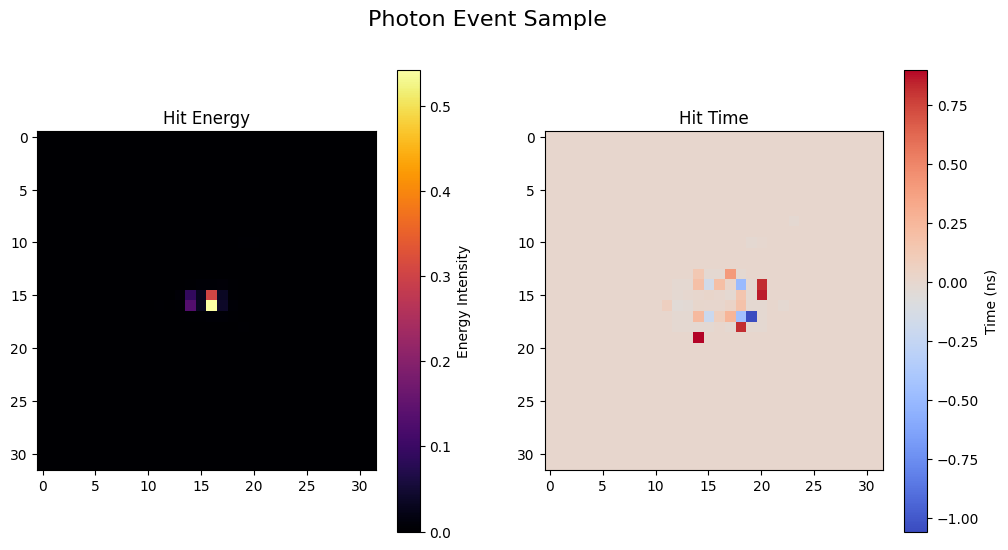

In [5]:
sample_idx = 0
image =x_photon[sample_idx]  # Shape: (32, 32, 2)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle("Photon Event Sample", fontsize=16)
# Plot Hit Energy
im1 = axes[0].imshow(image[:, :, 0], cmap="inferno")
axes[0].set_title("Hit Energy")
cbar1 = fig.colorbar(im1, ax=axes[0])
cbar1.set_label("Energy Intensity")

# Plot Hit Time
im2 = axes[1].imshow(image[:, :, 1], cmap="coolwarm")
axes[1].set_title("Hit Time")
cbar2 = fig.colorbar(im2, ax=axes[1])
cbar2.set_label("Time (ns)")

plt.show()


In [6]:
### Courtsey: https://github.com/tinygrad/tinygrad/tree/master/extra
import tinygrad.nn as nn 
from tinygrad import Tensor, dtypes
from tinygrad.nn.state import torch_load
from tinygrad.helpers import fetch, get_child

BatchNorm = nn.BatchNorm2d
Conv2d = nn.Conv2d
Linear = nn.Linear
class Bottleneck:
  # NOTE: stride_in_1x1=False, this is the v1.5 variant
  expansion = 4

  def __init__(self, in_planes, planes, stride=1, stride_in_1x1=False, groups=1, base_width=64):
    width = int(planes * (base_width / 64.0)) * groups
    # NOTE: the original implementation places stride at the first convolution (self.conv1), control with stride_in_1x1
    self.conv1 = Conv2d(in_planes, width, kernel_size=1, stride=stride if stride_in_1x1 else 1, bias=False)
    self.bn1 = BatchNorm(width)
    self.conv2 = Conv2d(width, width, kernel_size=3, padding=1, stride=1 if stride_in_1x1 else stride, groups=groups, bias=False)
    self.bn2 = BatchNorm(width)
    self.conv3 = Conv2d(width, self.expansion*planes, kernel_size=1, bias=False)
    self.bn3 = BatchNorm(self.expansion*planes)
    self.downsample = []
    if stride != 1 or in_planes != self.expansion*planes:
      self.downsample = [
        Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
        BatchNorm(self.expansion*planes)
      ]

  def __call__(self, x):
    out = self.bn1(self.conv1(x)).relu()
    out = self.bn2(self.conv2(out)).relu()
    out = self.bn3(self.conv3(out))
    out = out + x.sequential(self.downsample)
    out = out.relu()
    return out

class BasicBlock:
  expansion = 1

  def __init__(self, in_planes, planes, stride=1, groups=1, base_width=64):
    assert groups == 1 and base_width == 64, "BasicBlock only supports groups=1 and base_width=64"
    self.conv1 = Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = BatchNorm(planes)
    self.conv2 = Conv2d(planes, planes, kernel_size=3, padding=1, stride=1, bias=False)
    self.bn2 = BatchNorm(planes)
    self.downsample = []
    if stride != 1 or in_planes != self.expansion*planes:
      self.downsample = [
        Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
        BatchNorm(self.expansion*planes)
      ]

  def __call__(self, x):
    out = self.bn1(self.conv1(x)).relu()
    out = self.bn2(self.conv2(out))
    out = out + x.sequential(self.downsample)
    out = out.relu()
    return out

class ResNet:
  def __init__(self, num, num_classes=None, groups=1, width_per_group=64, stride_in_1x1=False):
    self.num = num
    self.block = {
      18: BasicBlock,
      34: BasicBlock,
      50: Bottleneck,
      101: Bottleneck,
      152: Bottleneck
    }[num]

    self.num_blocks = {
      18: [2,2,2,2],
      34: [3,4,6,3],
      50: [3,4,6,3],
      101: [3,4,23,3],
      152: [3,8,36,3]
    }[num]

    self.in_planes = 64

    self.groups = groups
    self.base_width = width_per_group
    self.conv1 = Conv2d(3, 64, kernel_size=7, stride=2, bias=False, padding=3)
    self.bn1 = BatchNorm(64)
    self.layer1 = self._make_layer(self.block, 64, self.num_blocks[0], stride=1, stride_in_1x1=stride_in_1x1)
    self.layer2 = self._make_layer(self.block, 128, self.num_blocks[1], stride=2, stride_in_1x1=stride_in_1x1)
    self.layer3 = self._make_layer(self.block, 256, self.num_blocks[2], stride=2, stride_in_1x1=stride_in_1x1)
    self.layer4 = self._make_layer(self.block, 512, self.num_blocks[3], stride=2, stride_in_1x1=stride_in_1x1)
    self.fc = Linear(512 * self.block.expansion, num_classes) if num_classes is not None else None

  def _make_layer(self, block, planes, num_blocks, stride, stride_in_1x1):
    strides = [stride] + [1] * (num_blocks-1)
    layers = []
    for stride in strides:
      if block == Bottleneck:
        layers.append(block(self.in_planes, planes, stride, stride_in_1x1, self.groups, self.base_width))
      else:
        layers.append(block(self.in_planes, planes, stride, self.groups, self.base_width))
      self.in_planes = planes * block.expansion
    return layers

  def forward(self, x):
    is_feature_only = self.fc is None
    if is_feature_only: features = []
    out = self.bn1(self.conv1(x)).relu()
    out = out.pad([1,1,1,1]).max_pool2d((3,3), 2)
    out = out.sequential(self.layer1)
    if is_feature_only: features.append(out)
    out = out.sequential(self.layer2)
    if is_feature_only: features.append(out)
    out = out.sequential(self.layer3)
    if is_feature_only: features.append(out)
    out = out.sequential(self.layer4)
    if is_feature_only: features.append(out)
    if not is_feature_only:
      out = out.mean([2,3])
      out = self.fc(out.cast(dtypes.float32))
      return out
    return features

  def __call__(self, x:Tensor) -> Tensor:
    return self.forward(x)

  def load_from_pretrained(self):
    model_urls = {
      (18, 1, 64): 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
      (34, 1, 64): 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
      (50, 1, 64): 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
      (50, 32, 4): 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
      (101, 1, 64): 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
      (152, 1, 64): 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    }

    self.url = model_urls[(self.num, self.groups, self.base_width)]
    for k, dat in torch_load(fetch(self.url)).items():
      try:
        obj: Tensor = get_child(self, k)
      except AttributeError as e:
        if 'fc.' in k and self.fc is None:
          continue

        raise e

      if 'fc.' in k and obj.shape != dat.shape:
        print("skipping fully connected layer")
        continue # Skip FC if transfer learning

      if 'bn' not in k and 'downsample' not in k: assert obj.shape == dat.shape, (k, obj.shape, dat.shape)
      obj.assign(dat.to(obj.device).reshape(obj.shape))


In [13]:
Tensor.training=True

In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from tinygrad.nn.state import get_parameters, get_state_dict, safe_save
from tinygrad.nn import optim, Conv2d

# Custom ResNet definition for 2 input channels
class ResNet2Channel(ResNet):
    def __init__(self, num, num_classes):
        super().__init__(num, num_classes)
        self.conv1 = Conv2d(2, 64, kernel_size=7, stride=2, padding=3)


def train_simplified():
    """Simplified training approach with model saving and Adam optimizer"""
    # Load data
    print("Loading photon data...")
    with h5py.File('/kaggle/input/electron-photon-cms-ml4sci/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
        x_photon = np.array(f['X'][:50000], dtype=np.float32)  # Increased to 50k samples
        y_photon = np.array(f['y'][:50000], dtype=np.float32)
    
    print("Loading electron data...")
    with h5py.File('/kaggle/input/electron-photon-cms-ml4sci/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r') as f:
        x_electron = np.array(f['X'][:50000], dtype=np.float32)  # Increased to 50k samples
        y_electron = np.array(f['y'][:50000], dtype=np.float32)
    
    print("Preparing data...")
    X = np.concatenate((x_photon, x_electron))
    Y = np.concatenate((y_photon, y_electron))
    Y = np.expand_dims(Y, axis=1)
    
    del x_photon, x_electron, y_photon, y_electron
    import gc; gc.collect()
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    train_size = int(0.8 * len(indices))
    train_indices = indices[:train_size]
    test_indices = indices[train_size:]
    
    print("Initializing model...")
    model = ResNet2Channel(18, num_classes=1)
    optimizer = optim.Adam(get_parameters(model), lr=1e-4)  # Adam optimizer
    
    epochs = 10  # Increased epochs
    batch_size = 32  # Increased batch size for T4 GPU
    best_val_loss = float('inf')
    
    print("Starting training...")
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        np.random.shuffle(train_indices)
        total_loss, batches = 0, 0
        
        for i in range(0, len(train_indices), batch_size):
            batch_idx = train_indices[i:i+batch_size]
            X_batch = X[batch_idx] / 255.0  # Normalize
            X_batch = np.transpose(X_batch, (0, 3, 1, 2))  # NHWC -> NCHW
            
            X_tensor = Tensor(X_batch)
            Y_tensor = Tensor(Y[batch_idx])
            
            out = model.forward(X_tensor)
            loss = ((out - Y_tensor) ** 2).mean()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.numpy()
            batches += 1
            
            if i % 100 == 0:
                print(f"  Batch {i//batch_size}, Loss: {loss.numpy():.4f}")
            
            del X_tensor, Y_tensor, out, loss
            gc.collect()
        
        avg_loss = total_loss / batches
        print(f"Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")
        
        # Validation
        val_loss, val_batches = 0, 0
        for i in range(0, min(len(test_indices), 1000), batch_size):
            batch_idx = test_indices[i:i+batch_size]
            X_batch = X[batch_idx] / 255.0
            X_batch = np.transpose(X_batch, (0, 3, 1, 2))
            
            out = model.forward(Tensor(X_batch))
            val_loss += ((out - Tensor(Y[batch_idx])) ** 2).mean().numpy()
            val_batches += 1
            
            del out
            gc.collect()
        
        val_avg = val_loss / val_batches
        print(f"Validation Loss: {val_avg:.4f}")
        
        # Save best model
        if val_avg < best_val_loss:
            best_val_loss = val_avg
            safe_save(get_state_dict(model), f'best_model_epoch{epoch+1}.safetensors')
            print(f"Saved new best model with val loss {val_avg:.4f}")

    # Save final model
    safe_save(get_state_dict(model), 'final_model.safetensors')
    print("Training complete. Final model saved.")

if __name__ == "__main__":
    train_simplified()

Loading photon data...
Loading electron data...
Preparing data...
Initializing model...
Starting training...
Epoch 1/10
  Batch 0, Loss: 0.4670
  Batch 25, Loss: 0.5599
  Batch 50, Loss: 0.2692
  Batch 75, Loss: 0.3464
  Batch 100, Loss: 0.3699
  Batch 125, Loss: 0.4365
  Batch 150, Loss: 0.2941
  Batch 175, Loss: 0.3066
  Batch 200, Loss: 0.2897
  Batch 225, Loss: 0.2901
  Batch 250, Loss: 0.3249
  Batch 275, Loss: 0.3713
  Batch 300, Loss: 0.2645
  Batch 325, Loss: 0.3292
  Batch 350, Loss: 0.2689
  Batch 375, Loss: 0.2908
  Batch 400, Loss: 0.3177
  Batch 425, Loss: 0.2141
  Batch 450, Loss: 0.2014
  Batch 475, Loss: 0.2663
  Batch 500, Loss: 0.2305
  Batch 525, Loss: 0.2832
  Batch 550, Loss: 0.2639
  Batch 575, Loss: 0.2540
  Batch 600, Loss: 0.2534
  Batch 625, Loss: 0.2899
  Batch 650, Loss: 0.2292
  Batch 675, Loss: 0.2573
  Batch 700, Loss: 0.2348
  Batch 725, Loss: 0.2192
  Batch 750, Loss: 0.2768
  Batch 775, Loss: 0.2358
  Batch 800, Loss: 0.2912
  Batch 825, Loss: 0.2445
 